In [341]:
from skimage.io import imread, imshow
from skimage.morphology import erosion, dilation, opening, closing, reconstruction
from skimage.morphology import disk, square
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import os

# Question 1

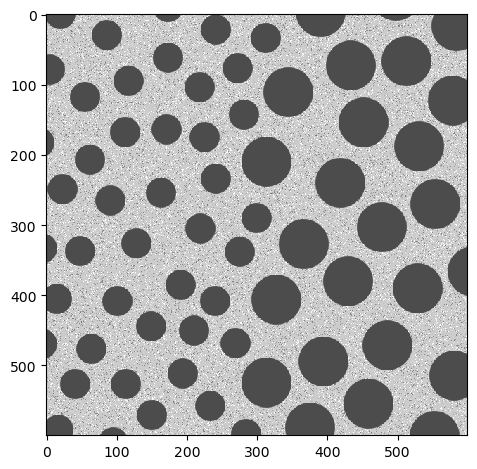

In [342]:
blobs_img = imread("chap5_images/dark_blobs_on_light_background.tif")
imshow(blobs_img, cmap='gray')

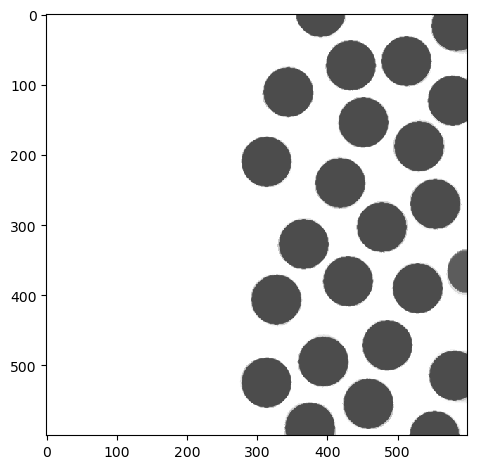

In [343]:
SE_closing = disk(28)
closing_result = closing(blobs_img, SE_closing)

imshow(closing_result, cmap='gray')

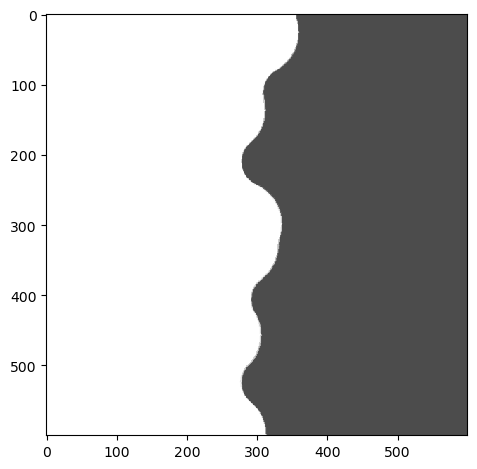

In [344]:
SE_opening = disk(60)
opening_result = opening(closing_result, SE_opening)
imshow(opening_result, cmap='gray')

C:\Users\JeannotMunganga\anaconda3\envs\digital-image-processing\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


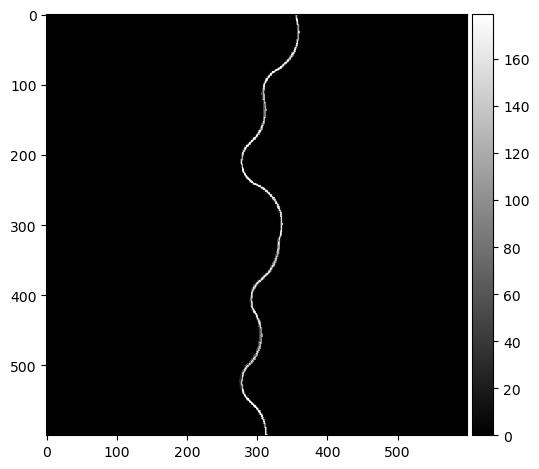

In [345]:
SE_gradient = square(3)
gradient_result = dilation(opening_result, SE_gradient) - erosion(opening_result, SE_gradient)
imshow(gradient_result, cmap='gray')

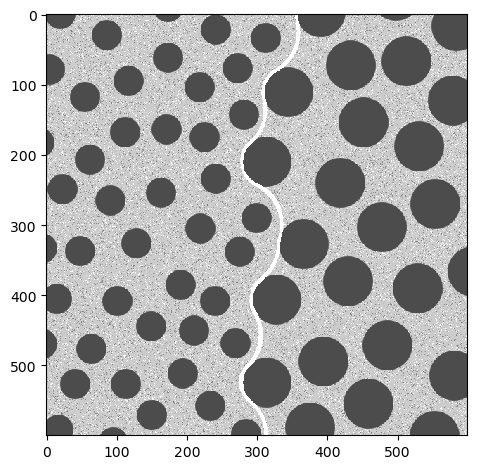

In [346]:
result = np.copy(blobs_img)
result[gradient_result > 0] = 255
imshow(result, cmap='gray')

# Question 2

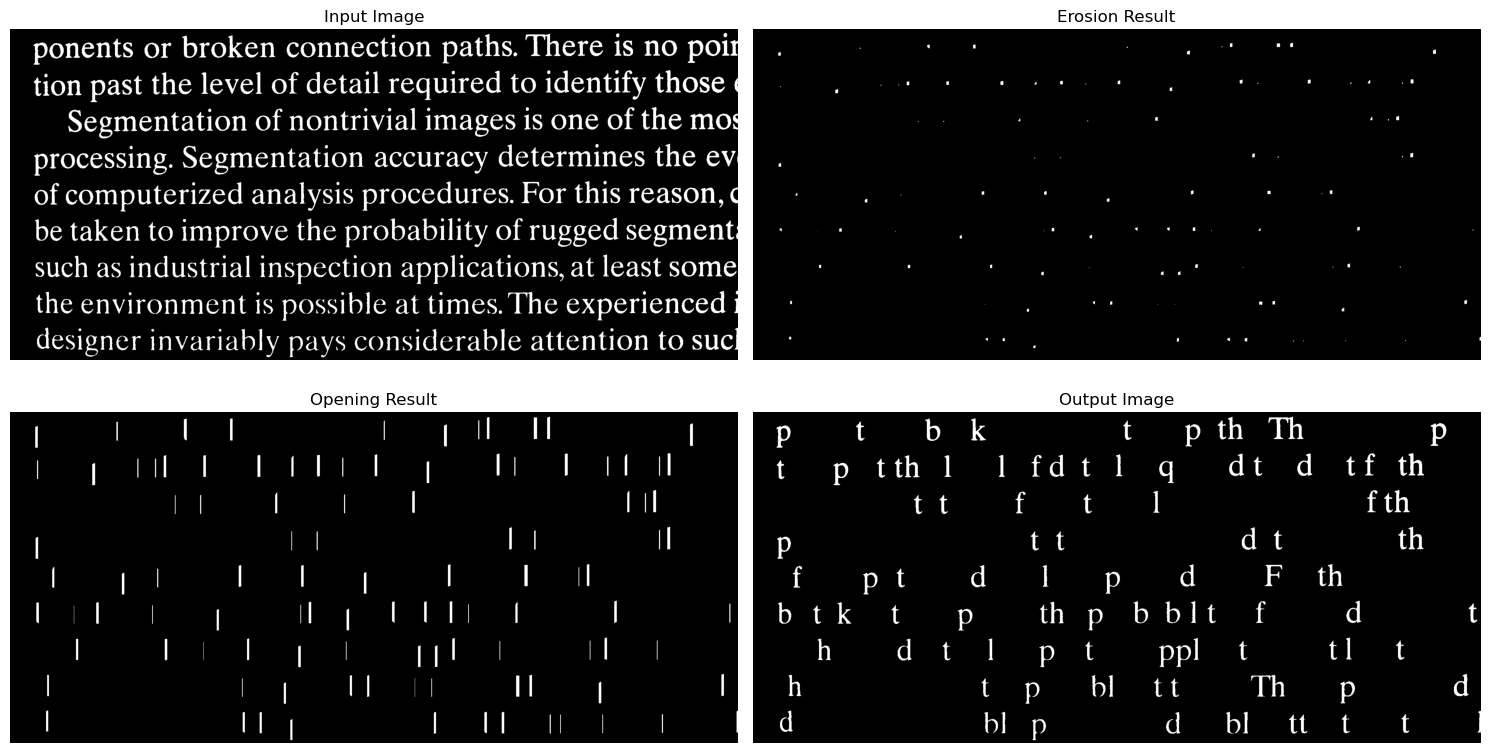

In [347]:
text_img = imread('chap5_images/text-image.tif')
F = erosion(text_img, np.ones((51, 1)))
opening_F = opening(text_img, np.ones((51, 1)))
Dg = F
while True:
    dilation_result = dilation(Dg, square(3))
    new_Dg = np.logical_and(text_img, dilation_result)
    
    if np.array_equal(Dg, new_Dg): 
        break
        
    Dg = new_Dg
    
fig, axes = plt.subplots(2,2, figsize=(15,8))
axes[0,0].imshow(text_img, cmap='gray')
axes[0,0].set_title('Input Image')
axes[0,0].axis('off')

axes[0,1].imshow(F, cmap='gray')
axes[0,1].set_title('Erosion Result')
axes[0,1].axis('off')

axes[1,0].imshow(opening_F, cmap='gray')
axes[1,0].set_title('Opening Result')
axes[1,0].axis('off')

axes[1,1].imshow(Dg, cmap='gray')
axes[1,1].set_title('Output Image')
axes[1,1].axis('off')
plt.tight_layout()

plt.show()

# Question 3

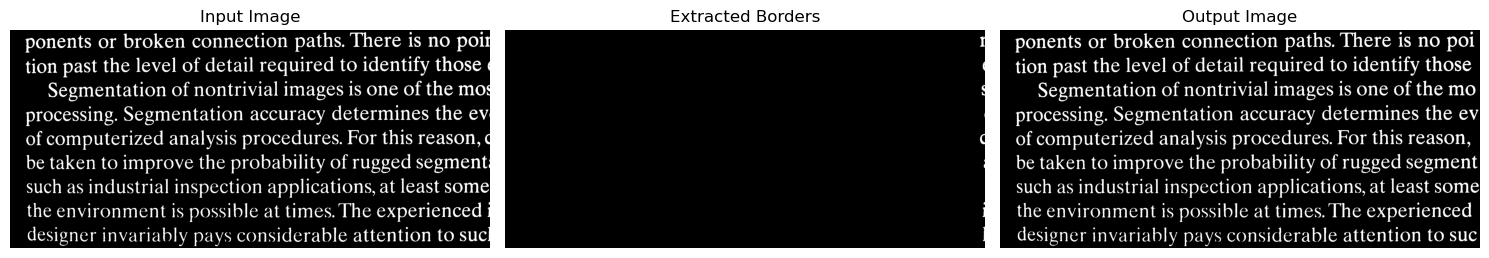

In [348]:
I = imread('chap5_images/text-image.tif')

# Create a mask for the border pixels
border_mask = np.zeros_like(text_img, dtype=bool)
border_mask[0, :] = True  # Top border
border_mask[-1, :] = True  # Bottom border
border_mask[:, 0] = True  # Left border
border_mask[:, -1] = True  # Right border

border_pixels = np.logical_and(border_mask, I)

F = border_pixels
while True:
    dilation_result = dilation(F, square(3))
    new_F = np.logical_and(text_img, dilation_result)
    
    if np.array_equal(new_F, F): 
        break
        
    F = new_F

fig, axes = plt.subplots(1,3, figsize=(15,8))
axes[0].imshow(I, cmap='gray')
axes[0].set_title('Input Image')
axes[0].axis('off')

axes[1].imshow(F, cmap='gray')
axes[1].set_title('Extracted Borders')
axes[1].axis('off')

axes[2].imshow(I.astype(dtype=np.int8) - F.astype(dtype=np.int8), cmap='gray')
axes[2].set_title('Output Image')
axes[2].axis('off')

plt.tight_layout()

plt.show()

# Question 4

In [349]:
#Reading images
training_set = []
training_labels=[]

test_set = []
test_labels=[]

for root, dirs, files in os.walk('dip_assignment2_images/att_faces_aligned'):
    folder_name = os.path.basename(root)
    folder_images = []
    
    for file in files:
        if file.endswith('.pgm'):
            path = os.path.join(root, file)
            folder_images.append(imread(path, as_gray=True)) 
    
    img_number = len(folder_images)
    if img_number > 0 :
        training_imgs = [folder_images[i] for i in range(img_number) if i % 2 == 0]
        test_imgs = [folder_images[i] for i in range(img_number) if i % 2 == 1]
        
        training_set += training_imgs
        test_set += test_imgs
        
        training_labels += [folder_name for _ in training_imgs]
        test_labels += [folder_name for _ in test_imgs]

C:\Users\JeannotMunganga\anaconda3\envs\digital-image-processing\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


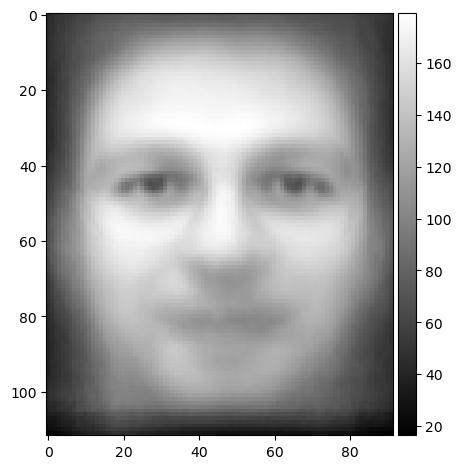

In [350]:
mean_img = np.mean(np.array(training_set), axis=0)
imshow(mean_img, cmap='gray')

In [351]:
phi = np.array(training_set) - mean_img

In [ ]:
num_images, height, width = phi.shape
X = phi.reshape(num_images, height * width).T

Sx = np.dot(X, X.T) / num_images

eigenvalues, eigenvectors = np.linalg.eigh(Sx)
sorted_eigenvectors = eigenvectors[:, np.argsort(eigenvalues)[::-1]]

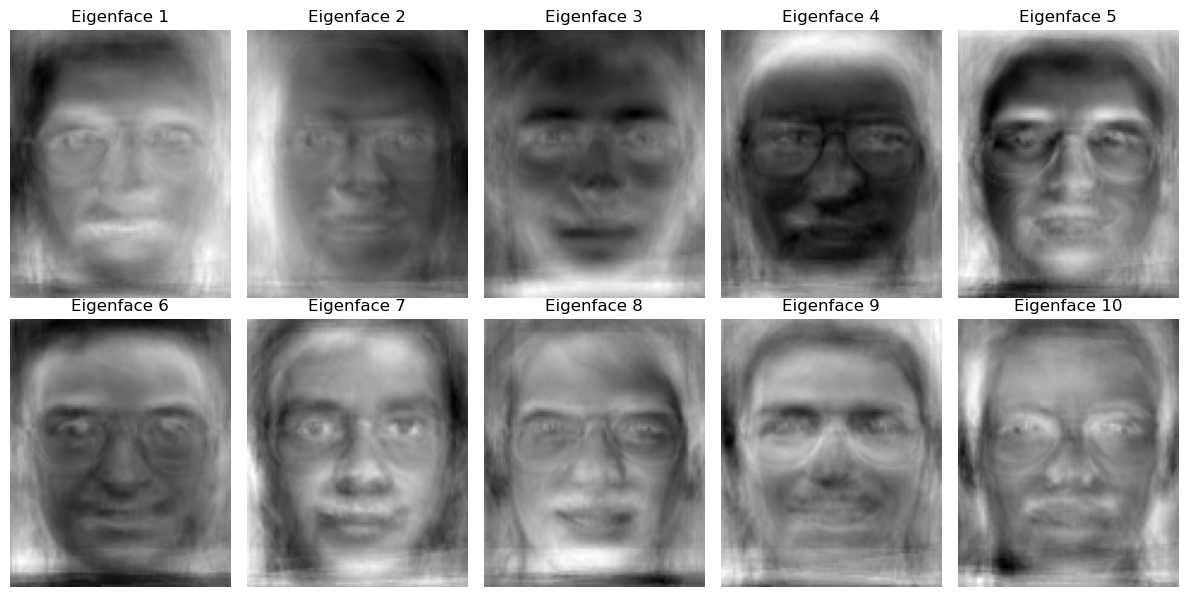

In [268]:
k = 10
top_k_eigenfaces = sorted_eigenvectors[:, :k]
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    eigenface = top_k_eigenfaces[:, i].reshape(height, width)
    ax.imshow(eigenface, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Eigenface {i+1}')
plt.tight_layout()
plt.show()

In [276]:
Y = np.dot(phi.reshape(num_images, -1), top_k_eigenfaces)

In [293]:
def NN_classifier(face, training_set, training_labels):
    distances = np.linalg.norm(training_set - face, axis=1)
    nn_index = np.argmin(distances)
    return training_labels[nn_index]

In [300]:
Ks = [20, 40, 60, 80, 100]
accuracies = []

for k in Ks:
    top_k_eigenfaces = sorted_eigenvectors[:, :k]
    Y = np.dot(phi.reshape(num_images, -1), top_k_eigenfaces)
    
    phi_test = np.array(test_set) - mean_img
    phi_test_projection = np.dot(phi_test.reshape(num_images, -1), top_k_eigenfaces)
    
    predictions = []
    for test_face in phi_test_projection:
        predicted_label = NN_classifier(test_face, Y, training_labels)
        predictions.append(predicted_label)
    
    # Step 13: Evaluate the recognition accuracy
    accuracy = accuracy_score(test_labels, predictions)
    accuracies.append(accuracy)
    print("Recognition Accuracy:", accuracy)

Recognition Accuracy: 0.79
Recognition Accuracy: 0.83
Recognition Accuracy: 0.845
Recognition Accuracy: 0.845
Recognition Accuracy: 0.83


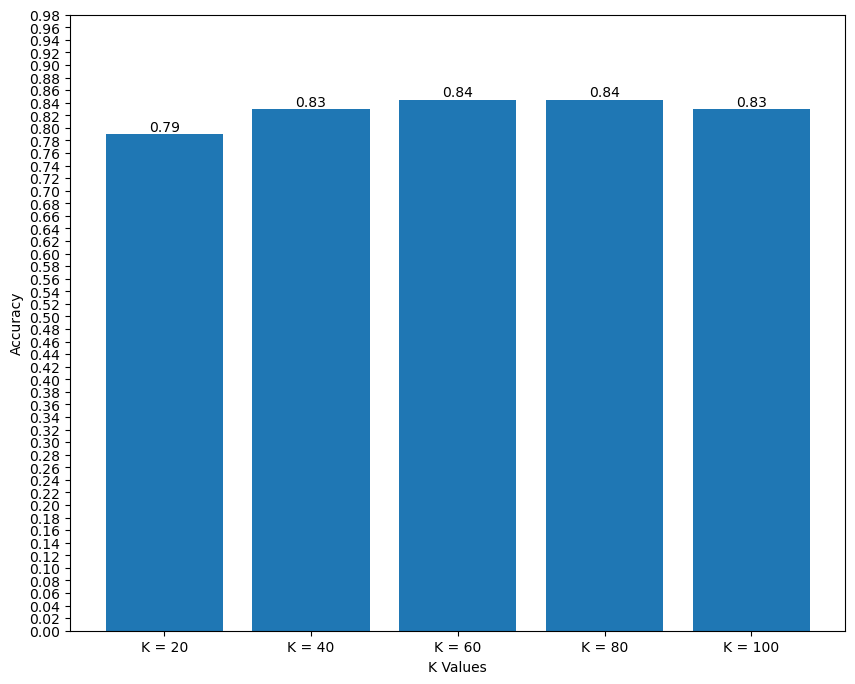

In [330]:
plt.figure(figsize=(10,8))

num_classes = 5
y_values = accuracies#np.random.rand(num_classes) * 0.01
x_labels = ['K = {}'.format(k) for k in Ks]

bars = plt.bar(np.arange(len(Ks)), y_values)
plt.xticks(np.arange(num_classes), x_labels)
plt.yticks(np.arange(0, 1, 0.02))
plt.xlabel('K Values')
plt.ylabel('Accuracy')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, '%.2f' % height, ha='center', va='bottom')

plt.show()